In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Marching Cubes

Marching cubes is an algorithm to extract a 2D surface mesh from a 3D volume.
This can be conceptualized as a 3D generalization of isolines on topographical
or weather maps. It works by iterating across the volume, looking for regions
which cross the level of interest. If such regions are found, triangulations
are generated and added to an output mesh. The final result is a set of
vertices and a set of triangular faces.

The algorithm requires a data volume and an isosurface value. For example, in
CT imaging Hounsfield units of +700 to +3000 represent bone. So, one potential
input would be a reconstructed CT set of data and the value +700, to extract
a mesh for regions of bone or bone-like density.

This implementation also works correctly on anisotropic datasets, where the
voxel spacing is not equal for every spatial dimension, through use of the
`spacing` kwarg.


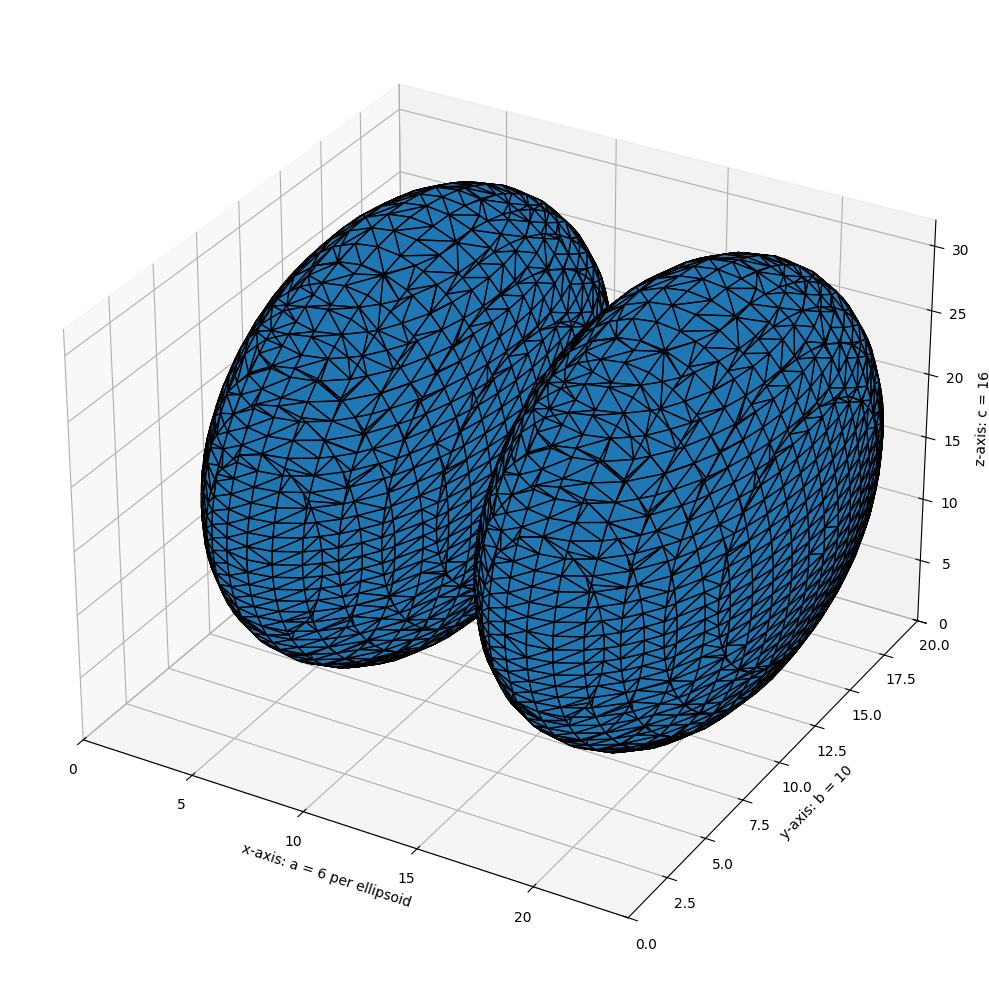

In [2]:
# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...], ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

In [3]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [4]:
fig = go.Figure(
    data=[go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color='skyblue',
        opacity=0.5
    )]
)
fig.show()

In [5]:
import open3d as o3d

In [6]:
pcd = o3d.io.read_point_cloud("bun_zipper.ply")
points = np.asarray(pcd.points)

In [7]:
def pcd_to_volume(points, voxel_size):
    # Determine the bounding box of the point cloud
    min_bound = points.min(axis=0) - voxel_size
    max_bound = points.max(axis=0) + voxel_size
    
    # Calculate grid dimensions
    shape = ((max_bound - min_bound) / voxel_size).astype(int) + 1
    
    # Map points to voxel indices
    indices = ((points - min_bound) / voxel_size).astype(int)
    
    # Create a 3D volume (density field)
    volume = np.zeros(shape, dtype=float)
    # Mark voxels that contain a point
    volume[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    
    return volume, min_bound

# Define voxel size (adjust for desired detail vs. performance)
voxel_size = 0.01 
volume, min_bound = pcd_to_volume(points, voxel_size)

In [8]:
# Extract the surface mesh using marching cubes
# The level should be between the min (0) and max (1) values in the volume
verts, faces, normals, values = measure.marching_cubes(volume, level=0.5) 

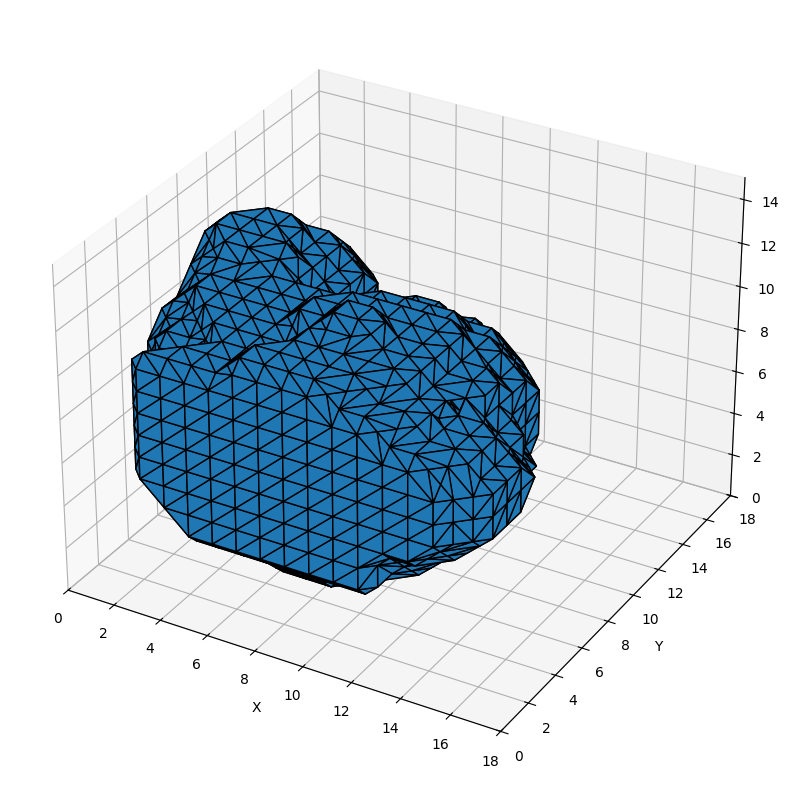

In [9]:
# Display resulting triangular mesh using Matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(0, volume.shape[0])
ax.set_ylim(0, volume.shape[1])
ax.set_zlim(0, volume.shape[2])

plt.show()


In [10]:
fig = go.Figure(
    data=[go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color='skyblue',
        opacity=0.5
    )]
)
fig.show()